## Time Series And Forecast Project

### Imports

In [1]:
#!pip install geopandas

In [2]:
#import geopandas as gpd

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
sns.set_style("whitegrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from scipy.fft import fft, ifft, fftfreq

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

#import warnings
#warnings.filterwarnings("ignore")

In [4]:
df_ber  = pd.read_csv('data_ber_tem/ECA_blended_custom/TG_STAID002759.txt',skiprows=18)
df_vlc  = pd.read_csv('data_vlc_viv/ECA_blended_custom/TG_STAID000237.txt',skiprows=18)

### Examining the Data

In [5]:
df_vlc.tail(5)

,SOUID,DATE,TG,Q_TG
30796,100885,20220224,122,0
30797,100885,20220225,113,0
30798,100885,20220226,117,0
30799,100885,20220227,126,0
30800,100885,20220228,138,0


In [6]:
df_vlc.columns

Index([' SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [7]:
df_vlc[df_vlc[' SOUID']!=100885]

,SOUID,DATE,TG,Q_TG
28318,908285,20150514,-9999,9


In [8]:
df_vlc[df_vlc['   TG']==-9999].count()
#df_vlc[df_vlc[' Q_TG']==9]

 SOUID      41
    DATE    41
   TG       41
 Q_TG       41
dtype: int64

In [9]:
df_vlc[df_vlc[' SOUID']!=100885]

,SOUID,DATE,TG,Q_TG
28318,908285,20150514,-9999,9


In [10]:
df_vlc.drop([' SOUID',' Q_TG'],axis=1, inplace=True)

In [11]:
df_vlc.rename(columns={'    DATE':'datetime','   TG':'temp'},inplace=True)

In [12]:
df_vlc.tail(6)

,datetime,temp
30795,20220223,124
30796,20220224,122
30797,20220225,113
30798,20220226,117
30799,20220227,126
30800,20220228,138


In [13]:
df_vlc['datetime'] = pd.to_datetime(df_vlc['datetime'], format='%Y%m%d')

In [14]:
df_vlc['month'] = df_vlc['datetime'].dt.month

In [15]:
df_vlc['year'] = df_vlc['datetime'].dt.year

In [16]:
df_vlc['day'] = df_vlc['datetime'].dt.day

In [17]:
df_vlc[df_vlc['temp']==-9999]

,datetime,temp,month,year,day
0,1937-11-01,-9999,11,1937,1
1,1937-11-02,-9999,11,1937,2
2,1937-11-03,-9999,11,1937,3
3,1937-11-04,-9999,11,1937,4
4,1937-11-05,-9999,11,1937,5
5,1937-11-06,-9999,11,1937,6
6,1937-11-07,-9999,11,1937,7
7,1937-11-08,-9999,11,1937,8
8,1937-11-09,-9999,11,1937,9
9,1937-11-10,-9999,11,1937,10


Nans: Block until timestep 84 and single timestep 28318

In [18]:
#df_vlc.temp[df_vlc.temp==-9999]=np.nan
df_vlc.loc[df_vlc.temp==-9999,'temp']=np.nan

In [19]:
df_vlc

,datetime,temp,month,year,day
0,1937-11-01,NaN,11,1937,1
1,1937-11-02,NaN,11,1937,2
2,1937-11-03,NaN,11,1937,3
3,1937-11-04,NaN,11,1937,4
4,1937-11-05,NaN,11,1937,5
...,...,...,...,...,...
30796,2022-02-24,122.0,2,2022,24
30797,2022-02-25,113.0,2,2022,25
30798,2022-02-26,117.0,2,2022,26
30799,2022-02-27,126.0,2,2022,27


In [20]:
#df_vlc = df_vlc[df_vlc['temp']>-9999]

In [21]:
df_vlc['temp'] = df_vlc['temp'] * 0.1

In [22]:
df_vlc

,datetime,temp,month,year,day
0,1937-11-01,NaN,11,1937,1
1,1937-11-02,NaN,11,1937,2
2,1937-11-03,NaN,11,1937,3
3,1937-11-04,NaN,11,1937,4
4,1937-11-05,NaN,11,1937,5
...,...,...,...,...,...
30796,2022-02-24,12.2,2,2022,24
30797,2022-02-25,11.3,2,2022,25
30798,2022-02-26,11.7,2,2022,26
30799,2022-02-27,12.6,2,2022,27


### Nans and unexpected values

In [23]:
df_vlc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30801 entries, 0 to 30800
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  30801 non-null  datetime64[ns]
 1   temp      30760 non-null  float64       
 2   month     30801 non-null  int64         
 3   year      30801 non-null  int64         
 4   day       30801 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.2 MB


In [24]:
df_vlc.isna().sum()

datetime     0
temp        41
month        0
year         0
day          0
dtype: int64

In [25]:
#sns.heatmap(df_vlc.isna())

There are 41 missing values marked originally with TG = -9999 and Q_TG = 9. One strategy is to drop them. 

Fill Nan 28318. Backfill

In [26]:
df_vlc.loc[28318]

datetime    2015-05-14 00:00:00
temp                        NaN
month                         5
year                       2015
day                          14
Name: 28318, dtype: object

In [27]:
df_vlc.temp.loc[28318]

nan

In [28]:
df_vlc['temp'].fillna(method='bfill', inplace=True)

In [29]:
df_vlc.temp.loc[28318]

22.400000000000002

Start from timestep 84 where the first block of Nans ends

#Get rid of the 29. February

In [30]:
df_Feb = df_vlc[df_vlc['month']==2]

In [31]:
df_29Feb = df_Feb[df_Feb['day']==29]

In [32]:
#df_vlc[df_vlc['month']==2][df_vlc['day']==29].drop(axis=0)

In [33]:
df_29Feb.index

Int64Index([  850,  2311,  3772,  5233,  6694,  8155,  9616, 11077, 12538,
            13999, 15460, 16921, 18382, 19843, 21304, 22765, 24226, 25687,
            27148, 28609, 30070],
           dtype='int64')

In [34]:
df_29Feb

,datetime,temp,month,year,day
850,1940-02-29,12.7,2,1940,29
2311,1944-02-29,9.3,2,1944,29
3772,1948-02-29,10.8,2,1948,29
5233,1952-02-29,11.3,2,1952,29
6694,1956-02-29,9.9,2,1956,29
8155,1960-02-29,17.0,2,1960,29
9616,1964-02-29,15.2,2,1964,29
11077,1968-02-29,10.7,2,1968,29
12538,1972-02-29,10.8,2,1972,29
13999,1976-02-29,10.5,2,1976,29


In [35]:
len(df_vlc)

30801

In [36]:
for i in df_29Feb.index :
    df_vlc.drop([i], inplace=True)

In [37]:
len(df_vlc)

30780

Getting rid of the 83 first rows full of Nans

In [38]:
#df_vlc = df_vlc[84:]
list=[]
for i in range(84) :
    list.append(i)
df_vlc.drop(list, inplace=True)

In [39]:
df_vlc

,datetime,temp,month,year,day
84,1938-01-24,10.0,1,1938,24
85,1938-01-25,9.6,1,1938,25
86,1938-01-26,10.9,1,1938,26
87,1938-01-27,10.4,1,1938,27
88,1938-01-28,12.6,1,1938,28
...,...,...,...,...,...
30796,2022-02-24,12.2,2,2022,24
30797,2022-02-25,11.3,2,2022,25
30798,2022-02-26,11.7,2,2022,26
30799,2022-02-27,12.6,2,2022,27


In [40]:
df_vlc.set_index('datetime',inplace=True)

In [41]:
df_vlc.reset_index(inplace=True)

In [42]:
df_vlc

,datetime,temp,month,year,day
0,1938-01-24,10.0,1,1938,24
1,1938-01-25,9.6,1,1938,25
2,1938-01-26,10.9,1,1938,26
3,1938-01-27,10.4,1,1938,27
4,1938-01-28,12.6,1,1938,28
...,...,...,...,...,...
30691,2022-02-24,12.2,2,2022,24
30692,2022-02-25,11.3,2,2022,25
30693,2022-02-26,11.7,2,2022,26
30694,2022-02-27,12.6,2,2022,27


In [43]:
df_vlc['timestep'] = range(len(df_vlc))

In [44]:
df_vlc

,datetime,temp,month,year,day,timestep
0,1938-01-24,10.0,1,1938,24,0
1,1938-01-25,9.6,1,1938,25,1
2,1938-01-26,10.9,1,1938,26,2
3,1938-01-27,10.4,1,1938,27,3
4,1938-01-28,12.6,1,1938,28,4
...,...,...,...,...,...,...
30691,2022-02-24,12.2,2,2022,24,30691
30692,2022-02-25,11.3,2,2022,25,30692
30693,2022-02-26,11.7,2,2022,26,30693
30694,2022-02-27,12.6,2,2022,27,30694


#### Trend and no Seasonality

In [45]:
X = df_vlc[['timestep']]
y = df_vlc['temp']

In [46]:
m = LinearRegression()
m.fit(X,y)

LinearRegression()

In [47]:
df_vlc['trend'] = m.predict(X)

<AxesSubplot:>

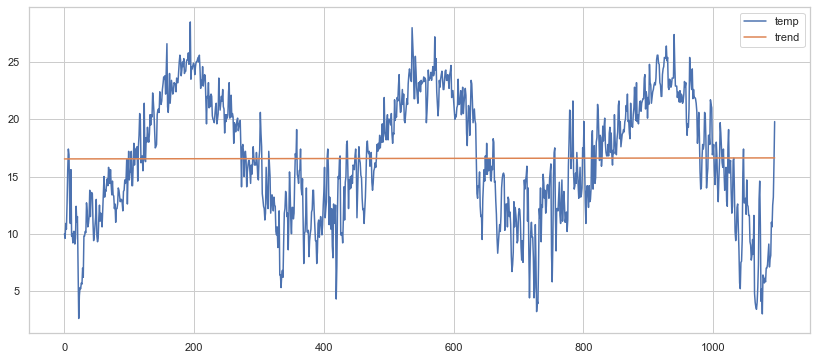

In [48]:
df_vlc.loc[:365*3,['temp','trend']].plot()

<AxesSubplot:>

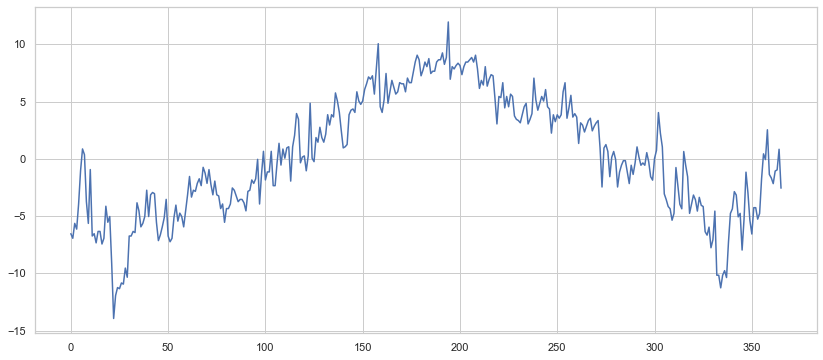

In [49]:
df_vlc['wo_trend'] = df_vlc['temp'] - df_vlc['trend']
df_vlc.loc[:365,'wo_trend'].plot()

In [50]:
df_vlc.describe()

,temp,month,year,day,timestep,trend,wo_trend
count,30696.000000,30696.000000,30696.000000,30696.000000,30696.000000,30696.000000,3.069600e+04
mean,17.789712,6.520459,1979.612783,15.722505,15347.500000,17.789712,4.296508e-15
std,5.566103,3.449745,24.277869,8.796826,8861.316268,0.723149,5.518928e+00
min,-1.100000,1.000000,1938.000000,1.000000,0.000000,16.537243,-1.817487e+01
25%,13.300000,4.000000,1959.000000,8.000000,7673.750000,17.163477,-4.539391e+00
50%,17.600000,7.000000,1980.000000,16.000000,15347.500000,17.789712,-2.604544e-01
75%,22.700000,10.000000,2001.000000,23.000000,23021.250000,18.415947,4.904645e+00
max,33.800000,12.000000,2022.000000,31.000000,30695.000000,19.042181,1.557748e+01


#### Seasonality and Trend

One-Hot-Encoding the 12 months of the year

In [51]:
seasonal_dummies_m = pd.get_dummies(df_vlc['month'], prefix='month',drop_first=True)

In [52]:
df_vlc_dummies_m = df_vlc.join(seasonal_dummies_m)

In [53]:
df_vlc_dummies_m.tail(3)

,datetime,temp,month,year,day,timestep,trend,wo_trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,1,0,0,0,0,0,0,0,0,0,0
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,1,0,0,0,0,0,0,0,0,0,0
30695,2022-02-28,13.8,2,2022,28,30695,19.042181,-5.242181,1,0,0,0,0,0,0,0,0,0,0


In [54]:
X = df_vlc_dummies_m.drop(columns=['datetime','temp','month','year','day','trend','wo_trend'])
y = df_vlc['temp']

In [55]:
X.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [56]:
m.fit(X,y)

df_vlc ['trend + seasonal'] = m.predict(X)
df_vlc.tail(3)

,datetime,temp,month,year,day,timestep,trend,wo_trend,trend + seasonal
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,13.377023
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,13.377106
30695,2022-02-28,13.8,2,2022,28,30695,19.042181,-5.242181,13.377189


<AxesSubplot:>

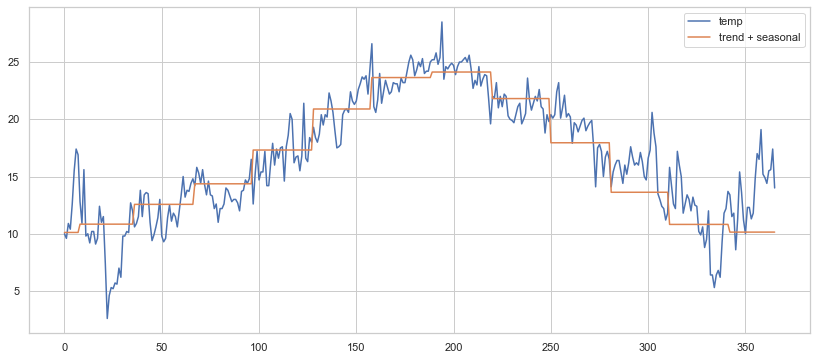

In [57]:
df_vlc.loc[0:365,['temp','trend + seasonal']].plot()

One-Hot-Encoding the 365 days of the year

In [58]:
df_vlc['n_day'] = df_vlc['month'] * 100 + df_vlc['day']

In [59]:
df_vlc['n_day'].nunique()

365

In [60]:
seasonal_dummies_d = pd.get_dummies(df_vlc['n_day'], prefix='day',drop_first=True)

In [61]:
seasonal_dummies_d.columns

Index(['day_102', 'day_103', 'day_104', 'day_105', 'day_106', 'day_107',
       'day_108', 'day_109', 'day_110', 'day_111',
       ...
       'day_1222', 'day_1223', 'day_1224', 'day_1225', 'day_1226', 'day_1227',
       'day_1228', 'day_1229', 'day_1230', 'day_1231'],
      dtype='object', length=364)

In [62]:
df_vlc_dummies_d = df_vlc.join(seasonal_dummies_d).drop(['trend + seasonal'],axis=1)

In [63]:
df_vlc_dummies_d.tail(3)

,datetime,temp,month,year,day,timestep,trend,wo_trend,n_day,day_102,...,day_1222,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,226,0,...,0,0,0,0,0,0,0,0,0,0
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,227,0,...,0,0,0,0,0,0,0,0,0,0
30695,2022-02-28,13.8,2,2022,28,30695,19.042181,-5.242181,228,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X = df_vlc_dummies_d.drop(columns=['datetime','temp','month','year','day','trend','wo_trend','n_day'])
y = df_vlc['temp']

In [65]:
X.columns

Index(['timestep', 'day_102', 'day_103', 'day_104', 'day_105', 'day_106',
       'day_107', 'day_108', 'day_109', 'day_110',
       ...
       'day_1222', 'day_1223', 'day_1224', 'day_1225', 'day_1226', 'day_1227',
       'day_1228', 'day_1229', 'day_1230', 'day_1231'],
      dtype='object', length=365)

In [66]:
m.fit(X,y)

df_vlc ['trend + seasonal'] = m.predict(X)
df_vlc.tail(3)

,datetime,temp,month,year,day,timestep,trend,wo_trend,trend + seasonal,n_day
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,13.787052,226
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,13.630581,227
30695,2022-02-28,13.8,2,2022,28,30695,19.042181,-5.242181,13.819993,228


<AxesSubplot:>

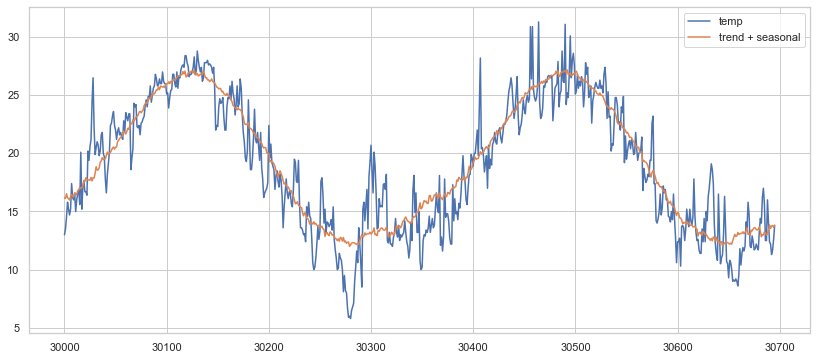

In [67]:
df_vlc.loc[30000:,['temp','trend + seasonal']].plot()

Determining seasonality without trend with .groupby

Fourier Transformation

#### Extracting the reminder

In [68]:
df_vlc['remainder'] = df_vlc['temp'] - df_vlc['trend + seasonal']

<AxesSubplot:>

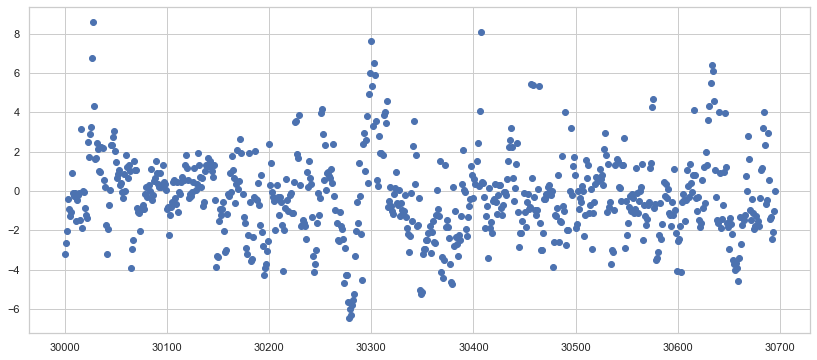

In [69]:
df_vlc.loc[30000:,'remainder'].plot(style='o')

In [70]:
df_vlc.tail(6)

,datetime,temp,month,year,day,timestep,trend,wo_trend,trend + seasonal,n_day,remainder
30690,2022-02-23,12.4,2,2022,23,30690,19.041773,-6.641773,13.839993,223,-1.439993
30691,2022-02-24,12.2,2,2022,24,30691,19.041855,-6.841855,13.539993,224,-1.339993
30692,2022-02-25,11.3,2,2022,25,30692,19.041937,-7.741937,13.761169,225,-2.461169
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,13.787052,226,-2.087052
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,13.630581,227,-1.030581
30695,2022-02-28,13.8,2,2022,28,30695,19.042181,-5.242181,13.819993,228,-0.019993


In [71]:
df_vlc.set_index('timestep')['remainder'].to_csv('temp_remainder.csv')

Automatic Analysis

#### Autoregressive Model

In [72]:
df_rem = pd.read_csv('temp_remainder.csv')

In [73]:
df_rem.tail(6)

,timestep,remainder
30690,30690,-1.439993
30691,30691,-1.339993
30692,30692,-2.461169
30693,30693,-2.087052
30694,30694,-1.030581
30695,30695,-0.019993


In [74]:
df_rem.columns

Index(['timestep', 'remainder'], dtype='object')

In [75]:
df_rem['lag1'] = df_rem['remainder'].shift(1)

In [76]:
df_rem.head(3)

,timestep,remainder,lag1
0,0,-0.481184,NaN
1,1,-0.965890,-0.481184
2,2,0.334110,-0.965890


Correlations

In [77]:
df_rem.corr()

,timestep,remainder,lag1
timestep,1.000000e+00,1.560284e-13,4.893004e-07
remainder,1.560284e-13,1.000000e+00,7.023722e-01
lag1,4.893004e-07,7.023722e-01,1.000000e+00


Plot remainder against lag1

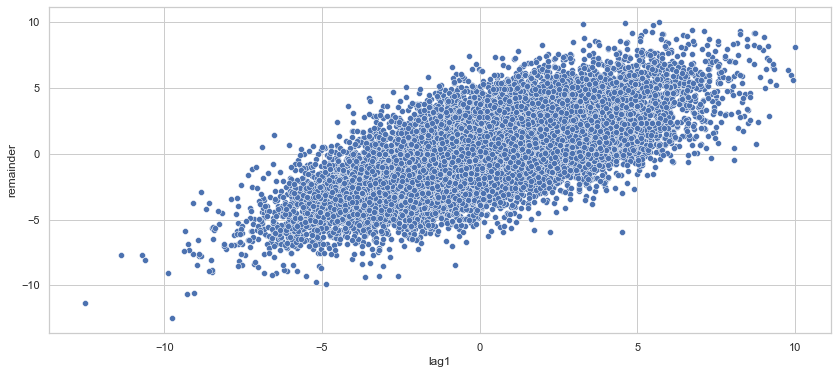

In [78]:
sns.scatterplot(x='lag1', y='remainder', data=df_rem);

In [79]:
#sns.regplot(data = df_rem, x = 'lag1', y = 'remainder')

Autoregressive Model

In [80]:
df_rem.dropna(inplace=True)

In [81]:
df_rem.head(3)

,timestep,remainder,lag1
1,1,-0.965890,-0.481184
2,2,0.334110,-0.965890
3,3,-0.176478,0.334110


In [82]:
X = df_rem[['lag1']]
y = df_rem['remainder']

In [83]:
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [84]:
df_rem['predictions_ar1'] = m.predict(X)
df_rem.head(3)

,timestep,remainder,lag1,predictions_ar1
1,1,-0.965890,-0.481184,-0.337955
2,2,0.334110,-0.965890,-0.678398
3,3,-0.176478,0.334110,0.234685


In [85]:
m.coef_, m.intercept_

(array([0.70237175]), 1.5218811535374705e-05)

In [86]:
m.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

<AxesSubplot:>

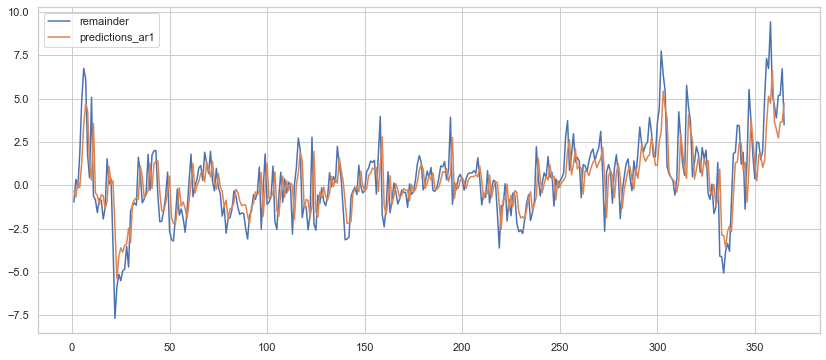

In [87]:
df_rem.loc[0:365,['remainder', 'predictions_ar1']].plot()
#df_vlc.loc[0:365,['temp','trend + seasonal']].plot()

Deciding wether to add lag2

In [88]:
df_rem['lag2'] = df_rem['remainder'].shift(2)
df_rem.head(3)

,timestep,remainder,lag1,predictions_ar1,lag2
1,1,-0.965890,-0.481184,-0.337955,NaN
2,2,0.334110,-0.965890,-0.678398,NaN
3,3,-0.176478,0.334110,0.234685,-0.96589


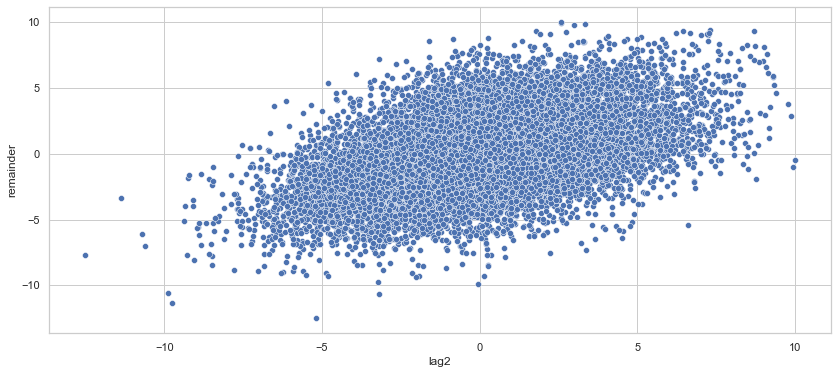

In [89]:
sns.scatterplot(x='lag2', y='remainder', data=df_rem);

In [90]:
round(df_rem[['remainder', 'lag1', 'lag2']].corr(), 2)

,remainder,lag1,lag2
remainder,1.0,0.7,0.5
lag1,0.7,1.0,0.7
lag2,0.5,0.7,1.0


Statsmodels tools: plot auto-correlation and plot partial auto-correlation

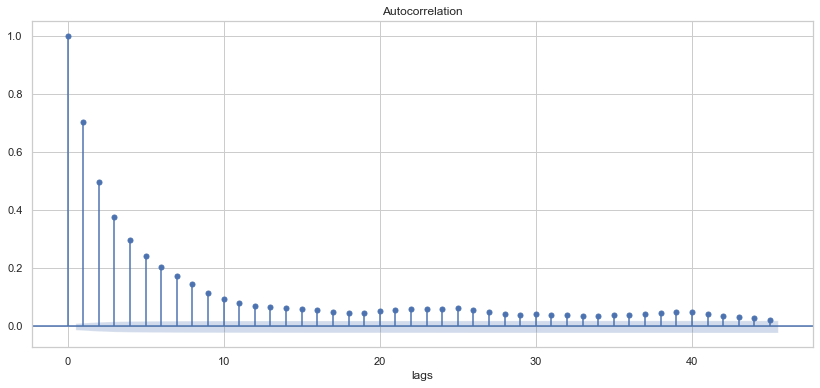

In [91]:
plot_acf(df_rem['remainder'])
plt.xlabel('lags');

Partial Autocorrelation

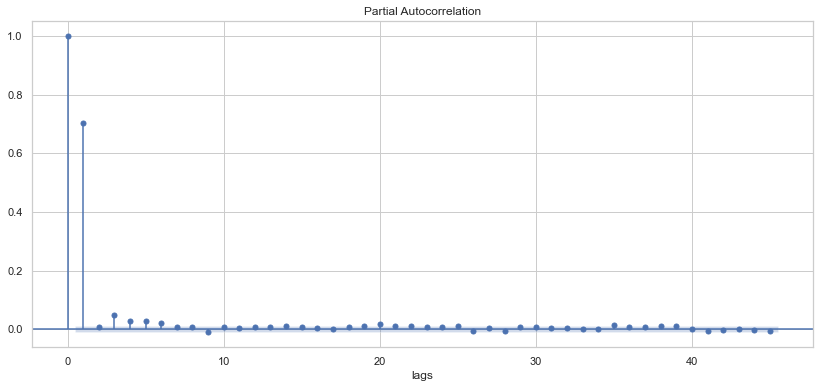

In [92]:
plot_pacf(df_rem['remainder'])
plt.xlabel('lags');

Evaluation

In [93]:
selected_order = ar_select_order(df_vlc['remainder'], maxlag = 12)
selected_order.ar_lags

C:\Users\PC\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


array([1, 2, 3, 4, 5, 6])

In [94]:
n_lags = selected_order.ar_lags

In [95]:
#timeseriessplit

In [96]:
#test

#### Run full model with the selected lags

add the lags of the remainder to the training data

In [97]:
df_vlc.tail(3)

,datetime,temp,month,year,day,timestep,trend,wo_trend,trend + seasonal,n_day,remainder
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,13.787052,226,-2.087052
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,13.630581,227,-1.030581
30695,2022-02-28,13.8,2,2022,28,30695,19.042181,-5.242181,13.819993,228,-0.019993


In [98]:
for i in n_lags :
    df_vlc[f'lag{i}'] = df_rem['remainder'].shift(i)

In [99]:
df_vlc

,datetime,temp,month,year,day,timestep,trend,wo_trend,trend + seasonal,n_day,remainder,lag1,lag2,lag3,lag4,lag5,lag6
0,1938-01-24,10.0,1,1938,24,0,16.537243,-6.537243,10.481184,124,-0.481184,NaN,NaN,NaN,NaN,NaN,NaN
1,1938-01-25,9.6,1,1938,25,1,16.537324,-6.937324,10.565890,125,-0.965890,NaN,NaN,NaN,NaN,NaN,NaN
2,1938-01-26,10.9,1,1938,26,2,16.537406,-5.637406,10.565890,126,0.334110,-0.965890,NaN,NaN,NaN,NaN,NaN
3,1938-01-27,10.4,1,1938,27,3,16.537487,-6.137487,10.576478,127,-0.176478,0.334110,-0.965890,NaN,NaN,NaN,NaN
4,1938-01-28,12.6,1,1938,28,4,16.537569,-3.937569,10.717654,128,1.882346,-0.176478,0.334110,-0.965890,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,2022-02-24,12.2,2,2022,24,30691,19.041855,-6.841855,13.539993,224,-1.339993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,2.351772
30692,2022-02-25,11.3,2,2022,25,30692,19.041937,-7.741937,13.761169,225,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287,-0.672934
30693,2022-02-26,11.7,2,2022,26,30693,19.042018,-7.342018,13.787052,226,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287
30694,2022-02-27,12.6,2,2022,27,30694,19.042100,-6.442100,13.630581,227,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125


clean the dataframe

In [100]:
df_vlc_full = df_vlc.drop(columns=['month','year','day','wo_trend',
                                      'trend','n_day'])

now add daily dummies again

In [101]:
df_vlc_full = df_vlc_full.join(seasonal_dummies_d)

In [102]:
df_vlc_full.tail(6)

,datetime,temp,timestep,trend + seasonal,remainder,lag1,lag2,lag3,lag4,lag5,...,day_1222,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231
30690,2022-02-23,12.4,30690,13.839993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,2.351772,...,0,0,0,0,0,0,0,0,0,0
30691,2022-02-24,12.2,30691,13.539993,-1.339993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,...,0,0,0,0,0,0,0,0,0,0
30692,2022-02-25,11.3,30692,13.761169,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287,...,0,0,0,0,0,0,0,0,0,0
30693,2022-02-26,11.7,30693,13.787052,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125,...,0,0,0,0,0,0,0,0,0,0
30694,2022-02-27,12.6,30694,13.630581,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,...,0,0,0,0,0,0,0,0,0,0
30695,2022-02-28,13.8,30695,13.819993,-0.019993,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,...,0,0,0,0,0,0,0,0,0,0


#### run the full model

In [103]:
df_vlc_full.dropna(inplace=True)

In [104]:
X_full = df_vlc_full.drop(columns=['datetime','temp','trend + seasonal','remainder'])
y_full = df_vlc_full['temp']

In [105]:
X_full.columns

Index(['timestep', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'day_102',
       'day_103', 'day_104',
       ...
       'day_1222', 'day_1223', 'day_1224', 'day_1225', 'day_1226', 'day_1227',
       'day_1228', 'day_1229', 'day_1230', 'day_1231'],
      dtype='object', length=371)

In [106]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [107]:
df_vlc_full['predictions_full_model'] = m_full.predict(X_full)

In [108]:
df_vlc_full.tail(5)

,datetime,temp,timestep,trend + seasonal,remainder,lag1,lag2,lag3,lag4,lag5,...,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231,predictions_full_model
30691,2022-02-24,12.2,30691,13.539993,-1.339993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,...,0,0,0,0,0,0,0,0,0,12.641852
30692,2022-02-25,11.3,30692,13.761169,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287,...,0,0,0,0,0,0,0,0,0,12.893032
30693,2022-02-26,11.7,30693,13.787052,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125,...,0,0,0,0,0,0,0,0,0,12.107998
30694,2022-02-27,12.6,30694,13.630581,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,...,0,0,0,0,0,0,0,0,0,12.259824
30695,2022-02-28,13.8,30695,13.819993,-0.019993,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,...,0,0,0,0,0,0,0,0,0,13.069564


Plot

In [109]:
#coefficients
#m_full.coef_
m_full.intercept_

9.947528001995474

<AxesSubplot:>

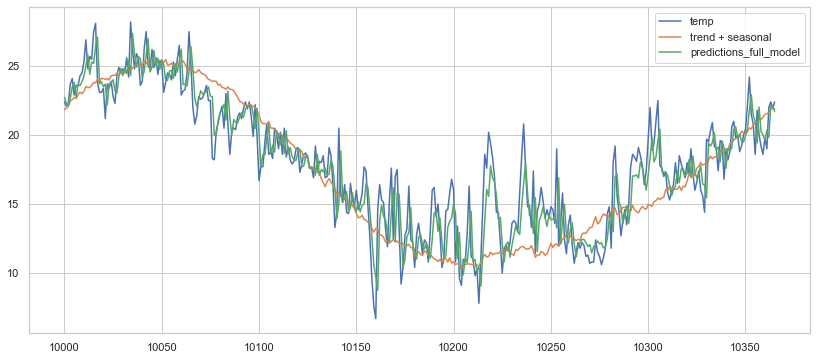

In [110]:
df_vlc_full.loc[10000:10365,['temp','trend + seasonal','predictions_full_model']].plot()

#### cross-validation

In [111]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [112]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 5116 5117 5118]
The validation data for the 1th iteration are the observations steps
    [ 5119  5120  5121 ... 10230 10231 10232]


The training data for the 2th iteration are the observations steps 
    [    0     1     2 ... 10230 10231 10232]
The validation data for the 2th iteration are the observations steps
    [10233 10234 10235 ... 15344 15345 15346]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 15344 15345 15346]
The validation data for the 3th iteration are the observations steps
    [15347 15348 15349 ... 20458 20459 20460]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 20458 20459 20460]
The validation data for the 4th iteration are the observations steps
    [20461 20462 20463 ... 25572 25573 25574]


The training data for the 5th iteration are the observations steps 
    [    0    

In [113]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [114]:
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.90334812, 0.89987361, 0.91021841, 0.9115    , 0.91198758])

In [115]:
result.mean()

0.9073855452829719

### forecast

In [116]:
df_vlc_full

,datetime,temp,timestep,trend + seasonal,remainder,lag1,lag2,lag3,lag4,lag5,...,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231,predictions_full_model
7,1938-01-31,16.9,7,10.777654,6.122346,6.744699,4.942346,1.882346,-0.176478,0.334110,...,0,0,0,0,0,0,0,0,0,15.367545
8,1938-02-01,12.8,8,11.082360,1.717640,6.122346,6.744699,4.942346,1.882346,-0.176478,...,0,0,0,0,0,0,0,0,0,15.317713
9,1938-02-02,10.9,9,10.482360,0.417640,1.717640,6.122346,6.744699,4.942346,1.882346,...,0,0,0,0,0,0,0,0,0,11.772620
10,1938-02-03,15.6,10,10.531772,5.068228,0.417640,1.717640,6.122346,6.744699,4.942346,...,0,0,0,0,0,0,0,0,0,11.114387
11,1938-02-04,9.8,11,10.423537,-0.623537,5.068228,0.417640,1.717640,6.122346,6.744699,...,0,0,0,0,0,0,0,0,0,14.223465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,2022-02-24,12.2,30691,13.539993,-1.339993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,...,0,0,0,0,0,0,0,0,0,12.641852
30692,2022-02-25,11.3,30692,13.761169,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287,...,0,0,0,0,0,0,0,0,0,12.893032
30693,2022-02-26,11.7,30693,13.787052,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125,...,0,0,0,0,0,0,0,0,0,12.107998
30694,2022-02-27,12.6,30694,13.630581,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,...,0,0,0,0,0,0,0,0,0,12.259824


In [117]:
df_vlc_full['remainder'] = df_vlc_full['temp'] - df_vlc_full['trend + seasonal']

In [118]:
df_vlc_full.tail(6)

,datetime,temp,timestep,trend + seasonal,remainder,lag1,lag2,lag3,lag4,lag5,...,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231,predictions_full_model
30690,2022-02-23,12.4,30690,13.839993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,2.351772,...,0,0,0,0,0,0,0,0,0,14.232279
30691,2022-02-24,12.2,30691,13.539993,-1.339993,-1.439993,0.543537,2.934125,-0.475287,-0.672934,...,0,0,0,0,0,0,0,0,0,12.641852
30692,2022-02-25,11.3,30692,13.761169,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287,...,0,0,0,0,0,0,0,0,0,12.893032
30693,2022-02-26,11.7,30693,13.787052,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125,...,0,0,0,0,0,0,0,0,0,12.107998
30694,2022-02-27,12.6,30694,13.630581,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,...,0,0,0,0,0,0,0,0,0,12.259824
30695,2022-02-28,13.8,30695,13.819993,-0.019993,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,...,0,0,0,0,0,0,0,0,0,13.069564


Creating a single future step

In [119]:
X_full.tail(3)

,timestep,lag1,lag2,lag3,lag4,lag5,lag6,day_102,day_103,day_104,...,day_1222,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231
30693,30693,-2.461169,-1.339993,-1.439993,0.543537,2.934125,-0.475287,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30694,30694,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,2.934125,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30695,30695,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993,0.543537,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
timestep = X_full['timestep'].max() + 1
days = [0] * 364
lag=[]
for i in range (0,6) :
    print(30695-i)
    lag.append(df_vlc_full.loc[30695-i,'remainder'])

30695
30694
30693
30692
30691
30690


In [121]:
timestep, lag

(30696,
 [-0.019992725169849734,
  -1.0305809604539444,
  -2.087051548699705,
  -2.4611691957604,
  -1.339992725179627,
  -1.4399927251713134])

In [122]:
X_future = [timestep]
X_future

[30696]

In [123]:
X_future.extend(days)
X_future.extend(lag)

In [124]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_full.columns

In [125]:
X_future

,timestep,lag1,lag2,lag3,lag4,lag5,lag6,day_102,day_103,day_104,...,day_1222,day_1223,day_1224,day_1225,day_1226,day_1227,day_1228,day_1229,day_1230,day_1231
0,30696,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.019993,-1.030581,-2.087052,-2.461169,-1.339993,-1.439993


In [126]:
X_future['day_301']=1

In [127]:
X_future['day_329']=0

In [128]:
fc = round(float(m_full.predict(X_future)),1)
print(f'The forecast for the 1. march: {fc}ºC')

The forecast for the 1. march: 12.9ºC


Next Steps:

### Plotly Maps

read geographic data

In [129]:
SHAPEFILE = './data/ne_110m_admin_0_countries.shp'

geopandas installation is not working

#### ARIMA

FFT

In [152]:
x = df_vlc_full['timestep']
y = df_vlc_full['temp']

In [157]:
yf = ifft(y)
#xf = fftfreq(N, T)[:N//2]
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
#plt.grid()
#plt.show()

NameError: name 'ifft' is not defined

In [145]:
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

In [146]:
x.shape

(600,)

In [147]:
y.shape

(600,)

In [153]:
#yf = fft(y)
xf = fft(x)